In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
from scipy.spatial import distance
!pip install moviepy
from moviepy.editor import VideoFileClip
import glob
from IPython.display import HTML
from google.colab import files
import copy

In [30]:
#we need keras1.2.2
!pip install keras==1.2.2
import keras 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
import numpy as np


## construct the tiny-yolo model ##

In [0]:
#helping codes


cnt=0
bottom1=0
frame1=0
frame2=0
bottom2=0
speed=0

def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])


class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()

def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.;
    l2 = x2 - w2 / 2.;
    left = max(l1, l2)
    r1 = x1 + w1 / 2.;
    r2 = x2 + w2 / 2.;
    right = min(r1, r2)
    return right - left;

def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);


def yolo_net_out_to_car_boxes(net_out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    class_num = 6
    boxes = []
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell
    
    probs = net_out[0 : prob_size]
    confs = net_out[prob_size : (prob_size + conf_size)]
    cords = net_out[(prob_size + conf_size) : ]
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])
    
    for grid in range(SS):
        for b in range(B):
            bx   = Box()
            bx.c =  confs[grid, b]
            bx.x = (cords[grid, b, 0] + grid %  S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  cords[grid, b, 2] ** sqrt 
            bx.h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c
            
            if p[class_num] >= threshold:
                bx.prob = p[class_num]
                boxes.append(bx)
                
    # combine boxes that are overlap
    boxes.sort(key=lambda b:b.prob,reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0: continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if box_iou(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]
    
    return boxes

def draw_box(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    global cnt
    cnt=cnt+1
    cv2.line(imgcv, (0,600), (1280,600), (255,255,255),2)
    cv2.line(imgcv, (0,400), (1280,400), (255,255,255),2)
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)
       # capture.get(CV_CAP_PROP_POS_FRAMES)
        global bottom1
        global bottom2
        global frame1
        global frame2
        global speed
        if(bot>400 and bot<600):
            if(bot<500 and bot>450 and bottom1==0):
                bottom1=bot
                frame1=cnt
            if(bot<550 and bot>500 and bottom1!=0):
                bottom2=bot
                frame2=cnt
            if(bottom1!=0 and bottom2!=0 and (frame2-frame1)!=0):
                speed=((bottom2-bottom1)*24)/(frame2-frame1)
                bottom1=bottom2
                bottom2=0
        else:
            bottom1=0               #speed detection 
            bottom2=0
        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)
        
        cv2.putText(imgcv,str(speed) , (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    return imgcv


In [32]:
print(keras.__version__)

1.2.2


In [0]:
keras.backend.set_image_dim_ordering('th')

In [0]:
model = Sequential()
smodel=Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256,name="out"))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [0]:
# model for siamese network

smodel=Sequential()
smodel.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(MaxPooling2D(pool_size=(2, 2)))
smodel.add(Convolution2D(32,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
smodel.add(Convolution2D(64,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
smodel.add(Convolution2D(128,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
smodel.add(Convolution2D(256,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
smodel.add(Convolution2D(512,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
smodel.add(Convolution2D(1024,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(Convolution2D(1024,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(Convolution2D(1024,3,3 ,border_mode='same'))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(Flatten())
smodel.add(Dense(256,name='out'))
smodel.add(Dense(4096))
smodel.add(LeakyReLU(alpha=0.1))
smodel.add(Dense(1470))

Loading weights


In [0]:
load_weights(model,'./yolo-tiny.weights')
load_weights(smodel,'./yolo-tiny.weights')
smodel.pop()
smodel.pop()
smodel.pop()


**future work, halted due to lack of data**



In [0]:

def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)


def cosine_distance_output_shape(shapes):
    return shapes[0]


def siameseclassifi(v1, v2):

    print('v1', v1)
    print('v2', v2)

    merged = Lambda(cosine_distance,
                    output_shape=cosine_distance_output_shape)([v1, v2])
    print('merge', merged)
    fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
    fc1 = Dropout(0.2)(fc1)
    fc1 = Activation("relu")(fc1)

    fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
    fc2 = Dropout(0.2)(fc2)
    fc2 = Activation("relu")(fc2)

    pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
    pred = Activation("softmax")(pred)
    print('pred', pred)
    return pred

TO get output from siamese sister

In [0]:
def compare(image):
   # plt.imshow(image)
    
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = smodel.predict(batch)
    return out

Anchor for siamese network

In [0]:
cap= cv2.VideoCapture("100.mp4")
f=cap.set(1,205)
r,fr=cap.read()
image = fr
#image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)

anchor=(smodel.predict(batch))


Main function for detection and tracking

In [0]:
cnt=0
boxflag=0
bbox=(0,0,0,0)
left=0
right=0
top=0
bot=0
bn=[]
def frame_func(image):
    imag=image
    cc=0
    global cnt
    global boxflag
    cnt=cnt+1
    if cnt==179:
        global bn
        bn=copy.deepcopy(image)
        cc=compare(bn)
    plt.imshow(image)
    boxes=[]
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    if boxflag==0:
      boxes=0
    global bbox
    
    global left
    global right
    global top
    global bot
    if boxflag==0:
        boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
        
        
        
        print("ii"+str(boxes)+"  "+str(cnt))
        
        anchor=compare(image)
        if 0 == distance.euclidean(anchor, cc):
            print(anchor)
            boxflag=1
            global tracker
            crop_dim=[[500,1280],[300,650]]
            [xmin,xmax] = crop_dim[0]
            [ymin,ymax] = crop_dim[1]
            h, w, _ = image.shape
            left  = int ((boxes[0].x - boxes[0].w/2.) * w)
            right = int ((boxes[0].x + boxes[0].w/2.) * w)
            top   = int ((boxes[0].y - boxes[0].h/2.) * h)
            bot   = int ((boxes[0].y + boxes[0].h/2.) * h)
            left = int(left*(xmax-xmin)/w + xmin)
            right = int(right*(xmax-xmin)/w + xmin)
            top = int(top*(ymax-ymin)/h + ymin)
            bot = int(bot*(ymax-ymin)/h + ymin)
            print("xx"+str(bbox))
        #    roi = image[top:bot, left:right]
            bbox=(left,top,right,bot)
          
           #Tracker doesnt work on google colab
          
         #   print(str(roi))
         #   tracker.init(image, bbox)
           # ok,bbox = tracker.update(image, (left,top),(right,bot)) 
        return draw_box(boxes,image,[[500,1280],[300,650]])
    
   
    
    
    if(boxflag==1):
        
       
        
        #Tracker doesnt work on google colab
        
       # ok,bbox = tracker.update(image, bbox)    
       # if ok:
           # cv2.rectangle(frame, bbox, Scalar( 255, 0, 0 ), 2, 1 )
           # print("ww"+str(bbox))
      cv2.rectangle(image, (left,top),(right,bot), ( 255, 255, 0 ), 2 )
      print("ww"+str(bbox))
    return draw_box(boxes,image,[[500,1280],[300,650]])

**sample video**

In [0]:
project_video_output = './output.mp4'
clip1 = VideoFileClip("./100.mp4")

In [56]:
!pip install opencv-contrib-python

In [0]:
def runvideo(clip1):
   # tracker = cv.TrackerMIL_create()   
    lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(project_video_output, audio=False)

ii[<__main__.Box object at 0x7f47268029e8>, <__main__.Box object at 0x7f4726802860>, <__main__.Box object at 0x7f4726802a58>, <__main__.Box object at 0x7f4726802898>]  1
[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


  0%|          | 1/1590 [00:00<03:59,  6.63it/s]

ii[]  3
ii[<__main__.Box object at 0x7f469786e5c0>, <__main__.Box object at 0x7f469786e4e0>, <__main__.Box object at 0x7f469786e390>]  5


  0%|          | 3/1590 [00:00<04:03,  6.51it/s]

ii[<__main__.Box object at 0x7f469786e5f8>, <__main__.Box object at 0x7f469786e048>, <__main__.Box object at 0x7f469786e780>]  7
ii[<__main__.Box object at 0x7f469786eb38>, <__main__.Box object at 0x7f469786ea58>, <__main__.Box object at 0x7f469786e898>]  9


  0%|          | 5/1590 [00:00<04:02,  6.55it/s]

ii[<__main__.Box object at 0x7f469786ec18>, <__main__.Box object at 0x7f469786e940>]  11
ii[<__main__.Box object at 0x7f469786ef98>, <__main__.Box object at 0x7f469786ef28>, <__main__.Box object at 0x7f469786eeb8>]  13


  0%|          | 7/1590 [00:01<04:01,  6.55it/s]

ii[<__main__.Box object at 0x7f469788c320>, <__main__.Box object at 0x7f469788c400>, <__main__.Box object at 0x7f469788c1d0>]  15
ii[<__main__.Box object at 0x7f469788c6d8>, <__main__.Box object at 0x7f469788c5f8>, <__main__.Box object at 0x7f469788c438>]  17


  1%|          | 9/1590 [00:01<04:03,  6.49it/s]

ii[<__main__.Box object at 0x7f469788c9b0>, <__main__.Box object at 0x7f469788c8d0>, <__main__.Box object at 0x7f469788c4e0>]  19
ii[<__main__.Box object at 0x7f469788cc50>, <__main__.Box object at 0x7f469788cb70>, <__main__.Box object at 0x7f469788c908>]  21


  1%|          | 11/1590 [00:01<04:01,  6.53it/s]

ii[]  23
ii[<__main__.Box object at 0x7f469788cf60>]  25


  1%|          | 13/1590 [00:02<04:01,  6.54it/s]

ii[<__main__.Box object at 0x7f469787f240>, <__main__.Box object at 0x7f469787f278>, <__main__.Box object at 0x7f469787f390>]  27
ii[<__main__.Box object at 0x7f469787f438>, <__main__.Box object at 0x7f469787f630>, <__main__.Box object at 0x7f469787f710>]  29


  1%|          | 15/1590 [00:02<04:00,  6.56it/s]

ii[<__main__.Box object at 0x7f469787f4a8>, <__main__.Box object at 0x7f469787f8d0>, <__main__.Box object at 0x7f469787f9b0>]  31
ii[<__main__.Box object at 0x7f469787fc50>, <__main__.Box object at 0x7f469787fb70>, <__main__.Box object at 0x7f469787f748>]  33


  1%|          | 17/1590 [00:02<03:59,  6.56it/s]

ii[<__main__.Box object at 0x7f469787f9e8>, <__main__.Box object at 0x7f469787fe10>, <__main__.Box object at 0x7f469787fe48>]  35
ii[<__main__.Box object at 0x7f469787fdd8>, <__main__.Box object at 0x7f469787ffd0>, <__main__.Box object at 0x7f4697866198>]  37


  1%|          | 19/1590 [00:02<03:58,  6.59it/s]

ii[<__main__.Box object at 0x7f46978660f0>, <__main__.Box object at 0x7f4697866208>, <__main__.Box object at 0x7f4697866390>]  39
ii[<__main__.Box object at 0x7f46978664a8>, <__main__.Box object at 0x7f46978663c8>, <__main__.Box object at 0x7f4697866630>]  41


  1%|▏         | 21/1590 [00:03<03:59,  6.55it/s]

ii[<__main__.Box object at 0x7f46978669b0>, <__main__.Box object at 0x7f46978665c0>, <__main__.Box object at 0x7f46978668d0>]  43
ii[<__main__.Box object at 0x7f46978669e8>, <__main__.Box object at 0x7f4697866898>, <__main__.Box object at 0x7f4697866b70>]  45


  1%|▏         | 23/1590 [00:03<04:00,  6.52it/s]

ii[<__main__.Box object at 0x7f4697866c50>, <__main__.Box object at 0x7f4697866e10>, <__main__.Box object at 0x7f4697866c88>]  47
ii[<__main__.Box object at 0x7f4697869198>, <__main__.Box object at 0x7f4697866fd0>, <__main__.Box object at 0x7f4697866e48>]  49


  2%|▏         | 25/1590 [00:03<03:59,  6.54it/s]

ii[<__main__.Box object at 0x7f4697869470>, <__main__.Box object at 0x7f4697869390>, <__main__.Box object at 0x7f46978690f0>]  51
ii[<__main__.Box object at 0x7f46978694a8>, <__main__.Box object at 0x7f4697869630>, <__main__.Box object at 0x7f4697869358>]  53


  2%|▏         | 27/1590 [00:04<03:56,  6.60it/s]

ii[<__main__.Box object at 0x7f4697869748>, <__main__.Box object at 0x7f46978698d0>, <__main__.Box object at 0x7f4697869710>]  55
ii[<__main__.Box object at 0x7f46978699e8>, <__main__.Box object at 0x7f4697869978>, <__main__.Box object at 0x7f4697869b70>]  57


  2%|▏         | 29/1590 [00:04<03:58,  6.55it/s]

ii[<__main__.Box object at 0x7f4697869c50>, <__main__.Box object at 0x7f4697869e10>]  59
ii[<__main__.Box object at 0x7f4697869e80>, <__main__.Box object at 0x7f4697869fd0>]  61


  2%|▏         | 31/1590 [00:04<03:56,  6.58it/s]

ii[]  63
ii[<__main__.Box object at 0x7f46978704e0>, <__main__.Box object at 0x7f46978706d8>, <__main__.Box object at 0x7f4697870668>, <__main__.Box object at 0x7f4697870630>, <__main__.Box object at 0x7f4697870518>]  65


  2%|▏         | 33/1590 [00:05<03:57,  6.54it/s]

ii[<__main__.Box object at 0x7f46978705c0>, <__main__.Box object at 0x7f46978708d0>, <__main__.Box object at 0x7f4697870588>, <__main__.Box object at 0x7f4697870978>]  67
ii[<__main__.Box object at 0x7f4697870908>, <__main__.Box object at 0x7f4697870b70>, <__main__.Box object at 0x7f4697870c18>]  69


  2%|▏         | 35/1590 [00:05<04:03,  6.39it/s]

ii[<__main__.Box object at 0x7f46978709b0>, <__main__.Box object at 0x7f4697870e10>]  71
ii[<__main__.Box object at 0x7f4697870e80>, <__main__.Box object at 0x7f4697870fd0>, <__main__.Box object at 0x7f4697870f98>]  73


  2%|▏         | 37/1590 [00:05<03:59,  6.49it/s]

ii[<__main__.Box object at 0x7f472af04208>, <__main__.Box object at 0x7f472af04198>, <__main__.Box object at 0x7f472af04390>]  75
ii[<__main__.Box object at 0x7f472af04438>]  77


  2%|▏         | 39/1590 [00:05<03:57,  6.52it/s]

ii[<__main__.Box object at 0x7f472af04780>, <__main__.Box object at 0x7f472af048d0>]  79
ii[<__main__.Box object at 0x7f472af04940>, <__main__.Box object at 0x7f472af04b70>]  81


  3%|▎         | 41/1590 [00:06<03:57,  6.52it/s]

ii[<__main__.Box object at 0x7f472af04be0>]  83
ii[<__main__.Box object at 0x7f472af04f60>, <__main__.Box object at 0x7f472af1b0f0>, <__main__.Box object at 0x7f472af04fd0>, <__main__.Box object at 0x7f472af04f98>]  85


  3%|▎         | 43/1590 [00:06<04:06,  6.28it/s]

ii[<__main__.Box object at 0x7f472af1b080>]  87
ii[<__main__.Box object at 0x7f472af1b4e0>]  89


  3%|▎         | 45/1590 [00:06<04:16,  6.02it/s]

ii[<__main__.Box object at 0x7f472af1b780>, <__main__.Box object at 0x7f472af1b7b8>, <__main__.Box object at 0x7f472af1b8d0>]  91
ii[<__main__.Box object at 0x7f472af1b898>, <__main__.Box object at 0x7f472af1bb70>, <__main__.Box object at 0x7f472af1b9e8>]  93


  3%|▎         | 47/1590 [00:07<04:24,  5.83it/s]

ii[<__main__.Box object at 0x7f472af1bc88>, <__main__.Box object at 0x7f472af1be10>, <__main__.Box object at 0x7f472af1beb8>, <__main__.Box object at 0x7f472af1bef0>]  95
ii[<__main__.Box object at 0x7f472af1bb38>, <__main__.Box object at 0x7f472aefd0f0>, <__main__.Box object at 0x7f472af1bf60>, <__main__.Box object at 0x7f472aefd198>]  97


  3%|▎         | 49/1590 [00:07<04:35,  5.58it/s]

ii[<__main__.Box object at 0x7f472aefd080>, <__main__.Box object at 0x7f472aefd438>, <__main__.Box object at 0x7f472aefd390>]  99
ii[]  101


  3%|▎         | 51/1590 [00:08<04:38,  5.52it/s]

ii[<__main__.Box object at 0x7f472aefd780>]  103


  3%|▎         | 52/1590 [00:08<04:56,  5.19it/s]

ii[<__main__.Box object at 0x7f472aefdc18>, <__main__.Box object at 0x7f472aefda20>, <__main__.Box object at 0x7f472aefdb70>]  105


  3%|▎         | 53/1590 [00:08<05:15,  4.87it/s]

ii[<__main__.Box object at 0x7f472aefdeb8>, <__main__.Box object at 0x7f472aefdb38>, <__main__.Box object at 0x7f472aefde10>]  107


  3%|▎         | 54/1590 [00:08<05:16,  4.86it/s]

ii[<__main__.Box object at 0x7f472af21048>, <__main__.Box object at 0x7f472aefdef0>, <__main__.Box object at 0x7f472aefdfd0>]  109
ii[<__main__.Box object at 0x7f472af21470>, <__main__.Box object at 0x7f472af210b8>, <__main__.Box object at 0x7f472af21438>, <__main__.Box object at 0x7f472af21390>]  111


  4%|▎         | 56/1590 [00:09<05:03,  5.05it/s]

ii[<__main__.Box object at 0x7f472af21630>, <__main__.Box object at 0x7f472af21320>]  113
ii[<__main__.Box object at 0x7f472af21978>, <__main__.Box object at 0x7f472af216a0>, <__main__.Box object at 0x7f472af218d0>]  115


  4%|▎         | 58/1590 [00:09<04:58,  5.13it/s]

ii[<__main__.Box object at 0x7f472af21c18>, <__main__.Box object at 0x7f472af217f0>, <__main__.Box object at 0x7f472af21b70>]  117
ii[<__main__.Box object at 0x7f472af21eb8>, <__main__.Box object at 0x7f472af21b38>, <__main__.Box object at 0x7f472af21e10>]  119


  4%|▍         | 60/1590 [00:09<04:54,  5.19it/s]

ii[<__main__.Box object at 0x7f472af15198>, <__main__.Box object at 0x7f472af21e48>, <__main__.Box object at 0x7f472af21fd0>, <__main__.Box object at 0x7f472af150f0>]  121
ii[<__main__.Box object at 0x7f472af15438>, <__main__.Box object at 0x7f472af15080>, <__main__.Box object at 0x7f472af15390>]  123


  4%|▍         | 62/1590 [00:10<04:50,  5.26it/s]

ii[<__main__.Box object at 0x7f472af15240>, <__main__.Box object at 0x7f472af15710>, <__main__.Box object at 0x7f472af15630>, <__main__.Box object at 0x7f472af156d8>]  125
ii[<__main__.Box object at 0x7f472af15978>, <__main__.Box object at 0x7f472af155c0>, <__main__.Box object at 0x7f472af158d0>]  127


  4%|▍         | 64/1590 [00:10<05:07,  4.95it/s]

ii[<__main__.Box object at 0x7f472af159e8>, <__main__.Box object at 0x7f472af15c18>, <__main__.Box object at 0x7f472af15b70>]  129
ii[<__main__.Box object at 0x7f472af15eb8>, <__main__.Box object at 0x7f472af15ba8>, <__main__.Box object at 0x7f472af15e10>]  131


  4%|▍         | 66/1590 [00:11<04:50,  5.25it/s]

ii[<__main__.Box object at 0x7f47268900f0>, <__main__.Box object at 0x7f472af15fd0>, <__main__.Box object at 0x7f472af15f28>]  133
ii[<__main__.Box object at 0x7f4726890438>, <__main__.Box object at 0x7f47268900b8>, <__main__.Box object at 0x7f4726890390>]  135


  4%|▍         | 68/1590 [00:11<04:44,  5.35it/s]

ii[<__main__.Box object at 0x7f4726890630>, <__main__.Box object at 0x7f47268904a8>]  137
ii[<__main__.Box object at 0x7f47268906a0>]  139


  4%|▍         | 70/1590 [00:11<04:53,  5.18it/s]

ii[]  141
ii[<__main__.Box object at 0x7f4726890eb8>, <__main__.Box object at 0x7f4726890cc0>, <__main__.Box object at 0x7f4726890e10>]  143


  5%|▍         | 72/1590 [00:12<05:07,  4.94it/s]

ii[<__main__.Box object at 0x7f472687a0f0>, <__main__.Box object at 0x7f4726890fd0>, <__main__.Box object at 0x7f4726890f28>]  145
ii[<__main__.Box object at 0x7f472687a390>, <__main__.Box object at 0x7f472687a198>]  147


  5%|▍         | 74/1590 [00:12<04:54,  5.15it/s]

ii[<__main__.Box object at 0x7f472687a6d8>, <__main__.Box object at 0x7f472687a438>, <__main__.Box object at 0x7f472687a630>]  149
ii[<__main__.Box object at 0x7f472687a8d0>, <__main__.Box object at 0x7f472687a710>]  151


  5%|▍         | 76/1590 [00:12<04:44,  5.31it/s]

ii[<__main__.Box object at 0x7f472687ab70>, <__main__.Box object at 0x7f472687a940>]  153
ii[<__main__.Box object at 0x7f472687ad30>, <__main__.Box object at 0x7f472687abe0>, <__main__.Box object at 0x7f472687aeb8>, <__main__.Box object at 0x7f472687acf8>, <__main__.Box object at 0x7f472687aef0>, <__main__.Box object at 0x7f472687ae48>]  155


  5%|▍         | 78/1590 [00:13<04:41,  5.36it/s]

ii[<__main__.Box object at 0x7f47268a41d0>, <__main__.Box object at 0x7f472687ae10>, <__main__.Box object at 0x7f47268a40f0>]  157


  5%|▍         | 79/1590 [00:13<04:52,  5.16it/s]

ii[<__main__.Box object at 0x7f47268a43c8>, <__main__.Box object at 0x7f47268a4048>, <__main__.Box object at 0x7f47268a4438>]  159
ii[<__main__.Box object at 0x7f47268a4550>, <__main__.Box object at 0x7f47268a4208>, <__main__.Box object at 0x7f47268a46d8>, <__main__.Box object at 0x7f47268a4668>]  161


  5%|▌         | 81/1590 [00:13<04:50,  5.19it/s]

ii[<__main__.Box object at 0x7f47268a4780>, <__main__.Box object at 0x7f47268a4710>, <__main__.Box object at 0x7f47268a4978>, <__main__.Box object at 0x7f47268a4908>]  163
ii[<__main__.Box object at 0x7f47268a4a20>, <__main__.Box object at 0x7f47268a4898>, <__main__.Box object at 0x7f47268a4c18>, <__main__.Box object at 0x7f47268a4ba8>]  165


  5%|▌         | 83/1590 [00:14<04:58,  5.05it/s]

ii[<__main__.Box object at 0x7f47268a4e48>, <__main__.Box object at 0x7f47268a4b70>, <__main__.Box object at 0x7f47268a4eb8>]  167
ii[<__main__.Box object at 0x7f4726884080>, <__main__.Box object at 0x7f47268a4f28>, <__main__.Box object at 0x7f4726884048>]  169


  5%|▌         | 85/1590 [00:14<04:45,  5.27it/s]

ii[<__main__.Box object at 0x7f4726884358>, <__main__.Box object at 0x7f4726884208>, <__main__.Box object at 0x7f4726884438>, <__main__.Box object at 0x7f4726884160>, <__main__.Box object at 0x7f4726884470>]  171
ii[<__main__.Box object at 0x7f47268845f8>, <__main__.Box object at 0x7f47268842e8>, <__main__.Box object at 0x7f47268846d8>, <__main__.Box object at 0x7f4726884390>, <__main__.Box object at 0x7f4726884710>]  173


  5%|▌         | 87/1590 [00:15<05:01,  4.99it/s]

ii[<__main__.Box object at 0x7f4726884898>, <__main__.Box object at 0x7f47268842b0>, <__main__.Box object at 0x7f4726884978>, <__main__.Box object at 0x7f47268849b0>]  175
ii[<__main__.Box object at 0x7f4726884a20>, <__main__.Box object at 0x7f4726884668>, <__main__.Box object at 0x7f4726884c18>, <__main__.Box object at 0x7f4726884908>, <__main__.Box object at 0x7f4726884ba8>]  177


  6%|▌         | 90/1590 [00:15<04:38,  5.39it/s]

ii[<__main__.Box object at 0x7f4726884b70>]  179
[[-0.2659268   0.17369308  0.18952508  0.11572474 -0.0083012   0.3455711
  -0.25767925 -0.14266579 -0.03534895  0.5499337  -0.2344006  -0.22191976
   0.5164812   0.03449739  0.12305799 -0.05451949  0.12243969  0.46441504
   0.362455    0.28746638 -0.19247521 -0.0375637  -0.19638403 -0.3341453
   0.12219316 -0.08042334 -0.09003052  0.13357696  0.35891852 -0.23805997
  -0.30132428 -0.0283366  -0.2034079   0.05489319  0.06213602  0.09976765
  -0.28197566 -0.00110573 -0.02327253 -0.01077308 -0.16132216  0.03276708
  -0.17971966 -0.11448181  0.0271452   0.42011878 -0.06983685 -0.5414067
  -0.0857427  -0.23705147 -0.03085454 -0.272952    0.07102977 -0.06135941
   0.38911211 -0.38740608  0.07751302 -0.18929085 -0.04603876 -0.13340862
  -0.07626042  0.11540997  0.17111367 -0.36986634  0.19748425 -0.00169326
   0.47899303  0.30138358 -0.02979026 -0.22238588 -0.07440571 -0.05830673
   0.122944   -0.10692838  0.15907529  0.01503998  0.08775511  0.0

  6%|▌         | 92/1590 [00:15<04:06,  6.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  6%|▌         | 94/1590 [00:16<03:43,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  6%|▌         | 96/1590 [00:16<03:32,  7.01it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  6%|▌         | 98/1590 [00:16<03:40,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  6%|▌         | 99/1590 [00:16<04:16,  5.81it/s]

ww(616, 375, 795, 460)


  6%|▋         | 101/1590 [00:17<03:58,  6.24it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  6%|▋         | 103/1590 [00:17<03:38,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 105/1590 [00:17<03:42,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 107/1590 [00:18<03:46,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 109/1590 [00:18<03:37,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 111/1590 [00:18<03:26,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 113/1590 [00:19<03:40,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 115/1590 [00:19<03:53,  6.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 117/1590 [00:19<03:37,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  7%|▋         | 119/1590 [00:19<03:48,  6.45it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 121/1590 [00:20<03:43,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 123/1590 [00:20<03:40,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 124/1590 [00:20<03:52,  6.32it/s]

ww(616, 375, 795, 460)


  8%|▊         | 126/1590 [00:21<03:44,  6.51it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 128/1590 [00:21<03:37,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 130/1590 [00:21<03:24,  7.15it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 131/1590 [00:21<03:17,  7.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  8%|▊         | 134/1590 [00:22<03:44,  6.50it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▊         | 136/1590 [00:22<03:36,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▊         | 137/1590 [00:22<03:36,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▉         | 140/1590 [00:23<03:49,  6.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▉         | 142/1590 [00:23<03:28,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▉         | 144/1590 [00:23<03:32,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▉         | 146/1590 [00:24<03:37,  6.64it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▉         | 148/1590 [00:24<03:25,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


  9%|▉         | 149/1590 [00:24<03:46,  6.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|▉         | 152/1590 [00:24<03:35,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|▉         | 154/1590 [00:25<03:29,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|▉         | 156/1590 [00:25<03:21,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|▉         | 158/1590 [00:25<03:31,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|█         | 160/1590 [00:26<03:34,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|█         | 162/1590 [00:26<03:34,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|█         | 164/1590 [00:26<03:32,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 10%|█         | 166/1590 [00:27<03:25,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█         | 168/1590 [00:27<03:31,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█         | 170/1590 [00:27<03:29,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█         | 172/1590 [00:27<03:35,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█         | 174/1590 [00:28<03:27,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█         | 176/1590 [00:28<03:23,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█         | 177/1590 [00:28<03:51,  6.09it/s]

ww(616, 375, 795, 460)


 11%|█▏        | 179/1590 [00:29<03:39,  6.43it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█▏        | 181/1590 [00:29<03:23,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 11%|█▏        | 182/1590 [00:29<03:42,  6.33it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 185/1590 [00:29<03:23,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 186/1590 [00:30<03:42,  6.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 189/1590 [00:30<03:30,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 190/1590 [00:30<03:47,  6.15it/s]

ww(616, 375, 795, 460)


 12%|█▏        | 192/1590 [00:31<03:40,  6.33it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 194/1590 [00:31<03:39,  6.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 196/1590 [00:31<03:23,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 12%|█▏        | 197/1590 [00:31<03:47,  6.11it/s]

ww(616, 375, 795, 460)


 13%|█▎        | 199/1590 [00:32<03:48,  6.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 201/1590 [00:32<03:37,  6.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 203/1590 [00:32<03:30,  6.58it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 205/1590 [00:33<03:31,  6.54it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 207/1590 [00:33<03:39,  6.30it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 209/1590 [00:33<03:37,  6.34it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 211/1590 [00:33<03:31,  6.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 13%|█▎        | 213/1590 [00:34<03:23,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▎        | 215/1590 [00:34<03:30,  6.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▎        | 217/1590 [00:34<03:33,  6.44it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▍        | 219/1590 [00:35<03:28,  6.58it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▍        | 220/1590 [00:35<03:43,  6.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▍        | 223/1590 [00:35<03:25,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▍        | 225/1590 [00:36<03:30,  6.48it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▍        | 227/1590 [00:36<03:16,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 14%|█▍        | 228/1590 [00:36<03:38,  6.23it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▍        | 231/1590 [00:37<03:35,  6.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▍        | 233/1590 [00:37<03:36,  6.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▍        | 235/1590 [00:37<03:32,  6.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▍        | 236/1590 [00:37<03:54,  5.79it/s]

ww(616, 375, 795, 460)


 15%|█▍        | 238/1590 [00:38<03:21,  6.69it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▌        | 239/1590 [00:38<03:24,  6.60it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▌        | 241/1590 [00:38<03:41,  6.09it/s]

ww(616, 375, 795, 460)


 15%|█▌        | 243/1590 [00:38<03:20,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 15%|█▌        | 244/1590 [00:39<03:35,  6.23it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 247/1590 [00:39<03:26,  6.51it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 248/1590 [00:39<03:40,  6.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 251/1590 [00:40<03:24,  6.55it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 252/1590 [00:40<03:20,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 255/1590 [00:40<03:47,  5.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 257/1590 [00:41<03:29,  6.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▌        | 258/1590 [00:41<03:20,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 16%|█▋        | 260/1590 [00:41<03:45,  5.89it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 263/1590 [00:42<03:42,  5.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 265/1590 [00:42<03:15,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 266/1590 [00:42<03:10,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 269/1590 [00:43<03:43,  5.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 271/1590 [00:43<03:17,  6.68it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 273/1590 [00:43<03:24,  6.44it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 274/1590 [00:44<03:44,  5.85it/s]

ww(616, 375, 795, 460)


 17%|█▋        | 276/1590 [00:44<03:22,  6.49it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 17%|█▋        | 277/1590 [00:44<03:22,  6.50it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 280/1590 [00:44<03:28,  6.29it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 282/1590 [00:45<03:28,  6.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 284/1590 [00:45<03:20,  6.53it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 286/1590 [00:45<03:22,  6.42it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 288/1590 [00:46<03:24,  6.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 290/1590 [00:46<03:09,  6.88it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 291/1590 [00:46<03:07,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 18%|█▊        | 293/1590 [00:46<03:26,  6.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▊        | 296/1590 [00:47<03:15,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▊        | 298/1590 [00:47<03:10,  6.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▉        | 300/1590 [00:48<03:06,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▉        | 302/1590 [00:48<03:03,  7.00it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▉        | 304/1590 [00:48<03:14,  6.60it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▉        | 306/1590 [00:48<03:13,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▉        | 308/1590 [00:49<03:02,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 19%|█▉        | 309/1590 [00:49<03:19,  6.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|█▉        | 312/1590 [00:49<03:10,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|█▉        | 314/1590 [00:50<03:19,  6.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|█▉        | 316/1590 [00:50<03:13,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|██        | 318/1590 [00:50<03:10,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|██        | 320/1590 [00:51<03:15,  6.48it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|██        | 322/1590 [00:51<03:22,  6.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 20%|██        | 324/1590 [00:51<03:18,  6.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██        | 326/1590 [00:51<03:11,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██        | 328/1590 [00:52<03:01,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██        | 330/1590 [00:52<03:08,  6.69it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██        | 331/1590 [00:52<03:25,  6.11it/s]

ww(616, 375, 795, 460)


 21%|██        | 333/1590 [00:53<03:20,  6.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██        | 335/1590 [00:53<03:00,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██        | 337/1590 [00:53<03:11,  6.54it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██▏       | 339/1590 [00:53<02:56,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 21%|██▏       | 341/1590 [00:54<03:09,  6.61it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 343/1590 [00:54<02:57,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 344/1590 [00:54<03:02,  6.83it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 347/1590 [00:55<03:13,  6.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 349/1590 [00:55<03:03,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 351/1590 [00:55<03:00,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 353/1590 [00:56<03:12,  6.42it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 355/1590 [00:56<03:06,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 22%|██▏       | 357/1590 [00:56<02:58,  6.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 359/1590 [00:56<03:01,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 361/1590 [00:57<03:03,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 363/1590 [00:57<03:03,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 364/1590 [00:57<02:56,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 367/1590 [00:58<03:08,  6.48it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 369/1590 [00:58<02:59,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 371/1590 [00:58<02:58,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 23%|██▎       | 372/1590 [00:58<03:16,  6.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▎       | 375/1590 [00:59<03:04,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▎       | 377/1590 [00:59<03:04,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▍       | 379/1590 [00:59<03:02,  6.62it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▍       | 380/1590 [01:00<03:05,  6.53it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▍       | 383/1590 [01:00<03:15,  6.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▍       | 385/1590 [01:00<02:54,  6.89it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▍       | 387/1590 [01:01<02:48,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 24%|██▍       | 389/1590 [01:01<02:59,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▍       | 391/1590 [01:01<02:57,  6.74it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▍       | 393/1590 [01:02<02:49,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▍       | 395/1590 [01:02<02:49,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▍       | 397/1590 [01:02<02:59,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▌       | 399/1590 [01:02<02:50,  7.00it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▌       | 400/1590 [01:03<02:58,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▌       | 403/1590 [01:03<03:07,  6.34it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 25%|██▌       | 405/1590 [01:03<02:53,  6.83it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▌       | 407/1590 [01:04<02:45,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▌       | 409/1590 [01:04<02:56,  6.69it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▌       | 411/1590 [01:04<02:54,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▌       | 412/1590 [01:04<03:04,  6.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▌       | 415/1590 [01:05<02:51,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▌       | 417/1590 [01:05<02:51,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▋       | 419/1590 [01:05<03:02,  6.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 26%|██▋       | 421/1590 [01:06<03:04,  6.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 423/1590 [01:06<02:55,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 425/1590 [01:06<02:57,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 427/1590 [01:07<02:51,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 429/1590 [01:07<02:42,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 431/1590 [01:07<02:41,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 433/1590 [01:08<02:47,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 435/1590 [01:08<02:41,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 27%|██▋       | 437/1590 [01:08<02:43,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 439/1590 [01:08<02:38,  7.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 441/1590 [01:09<02:36,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 442/1590 [01:09<03:01,  6.33it/s]

ww(616, 375, 795, 460)


 28%|██▊       | 444/1590 [01:09<02:53,  6.60it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 446/1590 [01:09<02:44,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 448/1590 [01:10<02:51,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 450/1590 [01:10<02:47,  6.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 28%|██▊       | 452/1590 [01:10<02:48,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▊       | 454/1590 [01:11<02:38,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▊       | 456/1590 [01:11<02:32,  7.43it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▉       | 458/1590 [01:11<02:48,  6.73it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▉       | 460/1590 [01:11<02:53,  6.53it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▉       | 462/1590 [01:12<02:52,  6.54it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▉       | 464/1590 [01:12<02:47,  6.73it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▉       | 466/1590 [01:12<02:38,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 29%|██▉       | 468/1590 [01:13<02:43,  6.88it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|██▉       | 470/1590 [01:13<02:43,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|██▉       | 472/1590 [01:13<02:44,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|██▉       | 474/1590 [01:13<02:42,  6.88it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|██▉       | 476/1590 [01:14<02:35,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|███       | 478/1590 [01:14<02:35,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|███       | 480/1590 [01:14<02:34,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|███       | 482/1590 [01:15<02:38,  7.01it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 30%|███       | 484/1590 [01:15<02:33,  7.19it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███       | 486/1590 [01:15<02:45,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███       | 488/1590 [01:15<02:38,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███       | 490/1590 [01:16<02:42,  6.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███       | 492/1590 [01:16<02:33,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███       | 494/1590 [01:16<02:33,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███       | 496/1590 [01:17<02:34,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███▏      | 498/1590 [01:17<02:32,  7.15it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 31%|███▏      | 500/1590 [01:17<02:31,  7.19it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 502/1590 [01:17<02:39,  6.80it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 504/1590 [01:18<02:38,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 506/1590 [01:18<02:33,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 508/1590 [01:18<02:32,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 510/1590 [01:19<02:37,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 512/1590 [01:19<02:30,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 514/1590 [01:19<02:40,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 32%|███▏      | 516/1590 [01:19<02:38,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 518/1590 [01:20<02:32,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 520/1590 [01:20<02:28,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 522/1590 [01:20<02:28,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 524/1590 [01:21<02:22,  7.50it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 526/1590 [01:21<02:22,  7.45it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 527/1590 [01:21<02:36,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 530/1590 [01:21<02:25,  7.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 33%|███▎      | 532/1590 [01:22<02:32,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▎      | 534/1590 [01:22<02:37,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▎      | 536/1590 [01:22<02:26,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▍      | 538/1590 [01:23<02:26,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▍      | 540/1590 [01:23<02:40,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▍      | 542/1590 [01:23<02:26,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▍      | 544/1590 [01:23<02:28,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▍      | 546/1590 [01:24<02:30,  6.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 34%|███▍      | 548/1590 [01:24<02:28,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▍      | 550/1590 [01:24<02:20,  7.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▍      | 552/1590 [01:25<02:24,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▍      | 554/1590 [01:25<02:20,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▍      | 556/1590 [01:25<02:21,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▌      | 558/1590 [01:25<02:21,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▌      | 560/1590 [01:26<02:21,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▌      | 562/1590 [01:26<02:19,  7.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 35%|███▌      | 564/1590 [01:26<02:26,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▌      | 566/1590 [01:27<02:23,  7.11it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▌      | 568/1590 [01:27<02:31,  6.74it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▌      | 570/1590 [01:27<02:27,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▌      | 572/1590 [01:27<02:21,  7.19it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▌      | 574/1590 [01:28<02:21,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▌      | 576/1590 [01:28<02:22,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▋      | 578/1590 [01:28<02:30,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 36%|███▋      | 580/1590 [01:29<02:33,  6.58it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 582/1590 [01:29<02:22,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 584/1590 [01:29<02:17,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 586/1590 [01:29<02:17,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 588/1590 [01:30<02:25,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 590/1590 [01:30<02:19,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 592/1590 [01:30<02:17,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 594/1590 [01:31<02:21,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 37%|███▋      | 596/1590 [01:31<02:25,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 598/1590 [01:31<02:20,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 600/1590 [01:31<02:15,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 602/1590 [01:32<02:15,  7.30it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 604/1590 [01:32<02:14,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 605/1590 [01:32<02:29,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 608/1590 [01:33<02:23,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 610/1590 [01:33<02:24,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 38%|███▊      | 612/1590 [01:33<02:20,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▊      | 614/1590 [01:33<02:27,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▊      | 616/1590 [01:34<02:24,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▉      | 618/1590 [01:34<02:18,  6.99it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▉      | 620/1590 [01:34<02:15,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▉      | 622/1590 [01:35<02:20,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▉      | 624/1590 [01:35<02:24,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▉      | 626/1590 [01:35<02:23,  6.73it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 39%|███▉      | 628/1590 [01:35<02:13,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|███▉      | 630/1590 [01:36<02:10,  7.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|███▉      | 632/1590 [01:36<02:10,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|███▉      | 634/1590 [01:36<02:09,  7.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|████      | 636/1590 [01:37<02:10,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|████      | 638/1590 [01:37<02:06,  7.50it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|████      | 640/1590 [01:37<02:05,  7.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 40%|████      | 642/1590 [01:37<02:16,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 644/1590 [01:38<02:14,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 646/1590 [01:38<02:13,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 648/1590 [01:38<02:08,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 650/1590 [01:39<02:04,  7.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 652/1590 [01:39<02:10,  7.19it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 654/1590 [01:39<02:06,  7.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████      | 655/1590 [01:39<02:20,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 41%|████▏     | 658/1590 [01:40<02:09,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 660/1590 [01:40<02:05,  7.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 662/1590 [01:40<02:12,  7.01it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 664/1590 [01:41<02:14,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 666/1590 [01:41<02:20,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 668/1590 [01:41<02:09,  7.11it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 670/1590 [01:41<02:09,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 672/1590 [01:42<02:06,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 42%|████▏     | 674/1590 [01:42<02:04,  7.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 676/1590 [01:42<02:05,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 678/1590 [01:42<02:10,  7.00it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 680/1590 [01:43<02:03,  7.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 682/1590 [01:43<02:11,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 684/1590 [01:43<02:12,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 686/1590 [01:44<02:10,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 688/1590 [01:44<02:02,  7.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 43%|████▎     | 690/1590 [01:44<02:04,  7.24it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▎     | 692/1590 [01:44<01:59,  7.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▎     | 694/1590 [01:45<02:06,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▍     | 696/1590 [01:45<02:10,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▍     | 698/1590 [01:45<02:03,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▍     | 700/1590 [01:46<02:02,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▍     | 702/1590 [01:46<02:02,  7.23it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▍     | 704/1590 [01:46<01:58,  7.47it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 44%|████▍     | 706/1590 [01:46<01:58,  7.48it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▍     | 708/1590 [01:47<01:51,  7.88it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▍     | 710/1590 [01:47<01:56,  7.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▍     | 712/1590 [01:47<02:10,  6.74it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▍     | 714/1590 [01:47<02:04,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▌     | 716/1590 [01:48<02:03,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▌     | 718/1590 [01:48<01:59,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▌     | 720/1590 [01:48<02:00,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 45%|████▌     | 722/1590 [01:49<02:06,  6.89it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▌     | 724/1590 [01:49<02:03,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▌     | 726/1590 [01:49<02:01,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▌     | 728/1590 [01:49<02:01,  7.12it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▌     | 730/1590 [01:50<01:59,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▌     | 732/1590 [01:50<02:07,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▌     | 734/1590 [01:50<02:03,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▋     | 736/1590 [01:51<01:57,  7.25it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 46%|████▋     | 738/1590 [01:51<01:59,  7.15it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 740/1590 [01:51<01:56,  7.30it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 742/1590 [01:51<01:55,  7.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 744/1590 [01:52<02:00,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 746/1590 [01:52<02:02,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 748/1590 [01:52<01:57,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 750/1590 [01:53<02:03,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 752/1590 [01:53<01:56,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 47%|████▋     | 754/1590 [01:53<01:56,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 756/1590 [01:53<01:54,  7.29it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 758/1590 [01:54<01:48,  7.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 760/1590 [01:54<01:46,  7.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 762/1590 [01:54<01:54,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 764/1590 [01:54<01:50,  7.47it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 766/1590 [01:55<01:49,  7.51it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 768/1590 [01:55<01:50,  7.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 770/1590 [01:55<01:49,  7.49it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 48%|████▊     | 771/1590 [01:55<01:56,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▊     | 774/1590 [01:56<01:54,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▉     | 776/1590 [01:56<01:52,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▉     | 778/1590 [01:56<01:49,  7.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▉     | 780/1590 [01:57<01:54,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▉     | 782/1590 [01:57<01:55,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▉     | 784/1590 [01:57<01:49,  7.34it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 49%|████▉     | 786/1590 [01:58<01:46,  7.54it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|████▉     | 788/1590 [01:58<01:56,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|████▉     | 790/1590 [01:58<01:53,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|████▉     | 792/1590 [01:58<01:52,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|████▉     | 794/1590 [01:59<01:46,  7.51it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|█████     | 796/1590 [01:59<01:42,  7.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|█████     | 797/1590 [01:59<01:57,  6.74it/s]

ww(616, 375, 795, 460)


 50%|█████     | 799/1590 [01:59<01:52,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|█████     | 801/1590 [02:00<01:48,  7.25it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 50%|█████     | 802/1590 [02:00<01:59,  6.61it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████     | 805/1590 [02:00<01:53,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████     | 807/1590 [02:01<01:47,  7.29it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████     | 809/1590 [02:01<01:47,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████     | 811/1590 [02:01<01:51,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████     | 813/1590 [02:01<01:57,  6.61it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████▏    | 815/1590 [02:02<01:47,  7.23it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 51%|█████▏    | 817/1590 [02:02<01:45,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 819/1590 [02:02<01:43,  7.46it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 821/1590 [02:03<01:53,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 823/1590 [02:03<01:44,  7.34it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 825/1590 [02:03<01:41,  7.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 827/1590 [02:03<01:47,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 829/1590 [02:04<01:45,  7.19it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 831/1590 [02:04<01:51,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 52%|█████▏    | 833/1590 [02:04<01:54,  6.60it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 835/1590 [02:04<01:48,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 837/1590 [02:05<01:51,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 839/1590 [02:05<01:47,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 841/1590 [02:05<01:43,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 843/1590 [02:06<01:43,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 845/1590 [02:06<01:42,  7.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 847/1590 [02:06<01:46,  7.01it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 53%|█████▎    | 849/1590 [02:06<01:46,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▎    | 851/1590 [02:07<01:51,  6.64it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▎    | 853/1590 [02:07<01:46,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▍    | 855/1590 [02:07<01:39,  7.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▍    | 857/1590 [02:08<01:39,  7.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▍    | 859/1590 [02:08<01:46,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▍    | 861/1590 [02:08<01:51,  6.53it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▍    | 863/1590 [02:08<01:43,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 54%|█████▍    | 865/1590 [02:09<01:38,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▍    | 867/1590 [02:09<01:37,  7.42it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▍    | 869/1590 [02:09<01:36,  7.50it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▍    | 871/1590 [02:10<01:43,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▍    | 873/1590 [02:10<01:39,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▌    | 875/1590 [02:10<01:43,  6.91it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▌    | 877/1590 [02:10<01:39,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▌    | 879/1590 [02:11<01:37,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 55%|█████▌    | 881/1590 [02:11<01:38,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▌    | 883/1590 [02:11<01:38,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▌    | 885/1590 [02:12<01:42,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▌    | 887/1590 [02:12<01:40,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▌    | 889/1590 [02:12<01:34,  7.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▌    | 891/1590 [02:12<01:35,  7.30it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▌    | 893/1590 [02:13<01:34,  7.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▋    | 895/1590 [02:13<01:37,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 56%|█████▋    | 897/1590 [02:13<01:39,  6.99it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 899/1590 [02:14<01:37,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 901/1590 [02:14<01:39,  6.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 903/1590 [02:14<01:40,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 905/1590 [02:14<01:36,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 907/1590 [02:15<01:35,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 909/1590 [02:15<01:42,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 911/1590 [02:15<01:38,  6.89it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 57%|█████▋    | 913/1590 [02:16<01:34,  7.15it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 915/1590 [02:16<01:41,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 916/1590 [02:16<01:48,  6.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 919/1590 [02:16<01:40,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 921/1590 [02:17<01:37,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 923/1590 [02:17<01:39,  6.73it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 925/1590 [02:17<01:46,  6.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 927/1590 [02:18<01:36,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 58%|█████▊    | 929/1590 [02:18<01:33,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▊    | 931/1590 [02:18<01:34,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▊    | 933/1590 [02:19<01:29,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▉    | 935/1590 [02:19<01:32,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▉    | 937/1590 [02:19<01:37,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▉    | 939/1590 [02:19<01:29,  7.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▉    | 941/1590 [02:20<01:28,  7.34it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▉    | 943/1590 [02:20<01:32,  6.99it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 59%|█████▉    | 945/1590 [02:20<01:38,  6.55it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|█████▉    | 947/1590 [02:21<01:35,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|█████▉    | 949/1590 [02:21<01:33,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|█████▉    | 951/1590 [02:21<01:30,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|█████▉    | 953/1590 [02:21<01:40,  6.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|██████    | 955/1590 [02:22<01:34,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|██████    | 957/1590 [02:22<01:31,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|██████    | 959/1590 [02:22<01:36,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 60%|██████    | 961/1590 [02:23<01:31,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████    | 963/1590 [02:23<01:29,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████    | 965/1590 [02:23<01:31,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████    | 967/1590 [02:24<01:38,  6.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████    | 969/1590 [02:24<01:33,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████    | 971/1590 [02:24<01:34,  6.58it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████    | 973/1590 [02:24<01:33,  6.58it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████▏   | 975/1590 [02:25<01:31,  6.73it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 61%|██████▏   | 977/1590 [02:25<01:24,  7.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 979/1590 [02:25<01:25,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 981/1590 [02:26<01:25,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 983/1590 [02:26<01:26,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 985/1590 [02:26<01:23,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 987/1590 [02:26<01:28,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 989/1590 [02:27<01:23,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 991/1590 [02:27<01:30,  6.60it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 62%|██████▏   | 993/1590 [02:27<01:27,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 995/1590 [02:28<01:23,  7.11it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 997/1590 [02:28<01:24,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 999/1590 [02:28<01:25,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 1001/1590 [02:28<01:22,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 1003/1590 [02:29<01:24,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 1005/1590 [02:29<01:23,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 1007/1590 [02:29<01:20,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 63%|██████▎   | 1009/1590 [02:30<01:21,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▎   | 1011/1590 [02:30<01:20,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▎   | 1012/1590 [02:30<01:21,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▍   | 1015/1590 [02:30<01:25,  6.74it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▍   | 1017/1590 [02:31<01:20,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▍   | 1019/1590 [02:31<01:22,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▍   | 1021/1590 [02:31<01:20,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▍   | 1023/1590 [02:32<01:22,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 64%|██████▍   | 1025/1590 [02:32<01:17,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▍   | 1027/1590 [02:32<01:16,  7.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▍   | 1029/1590 [02:32<01:17,  7.25it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▍   | 1031/1590 [02:33<01:20,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▍   | 1033/1590 [02:33<01:21,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▌   | 1035/1590 [02:33<01:23,  6.62it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▌   | 1037/1590 [02:34<01:24,  6.55it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▌   | 1039/1590 [02:34<01:22,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 65%|██████▌   | 1041/1590 [02:34<01:19,  6.88it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▌   | 1043/1590 [02:35<01:21,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▌   | 1045/1590 [02:35<01:24,  6.47it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▌   | 1047/1590 [02:35<01:19,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▌   | 1049/1590 [02:35<01:14,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▌   | 1051/1590 [02:36<01:21,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▌   | 1053/1590 [02:36<01:18,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▋   | 1055/1590 [02:36<01:15,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 66%|██████▋   | 1057/1590 [02:37<01:12,  7.33it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1059/1590 [02:37<01:13,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1061/1590 [02:37<01:18,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1063/1590 [02:37<01:17,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1065/1590 [02:38<01:14,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1067/1590 [02:38<01:12,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1069/1590 [02:38<01:11,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1070/1590 [02:38<01:16,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 67%|██████▋   | 1073/1590 [02:39<01:14,  6.91it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1074/1590 [02:39<01:22,  6.25it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1077/1590 [02:39<01:13,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1079/1590 [02:40<01:16,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1081/1590 [02:40<01:13,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1083/1590 [02:40<01:14,  6.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1085/1590 [02:41<01:12,  6.99it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1087/1590 [02:41<01:16,  6.55it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 68%|██████▊   | 1089/1590 [02:41<01:16,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▊   | 1091/1590 [02:42<01:10,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▊   | 1093/1590 [02:42<01:11,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▉   | 1095/1590 [02:42<01:10,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▉   | 1097/1590 [02:42<01:06,  7.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▉   | 1099/1590 [02:43<01:08,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▉   | 1101/1590 [02:43<01:10,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▉   | 1103/1590 [02:43<01:11,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 69%|██████▉   | 1105/1590 [02:44<01:04,  7.51it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|██████▉   | 1106/1590 [02:44<01:05,  7.42it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|██████▉   | 1109/1590 [02:44<01:11,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|██████▉   | 1111/1590 [02:44<01:09,  6.89it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|███████   | 1113/1590 [02:45<01:11,  6.64it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|███████   | 1115/1590 [02:45<01:16,  6.24it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|███████   | 1117/1590 [02:45<01:11,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 70%|███████   | 1119/1590 [02:46<01:06,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████   | 1121/1590 [02:46<01:10,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████   | 1123/1590 [02:46<01:12,  6.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████   | 1125/1590 [02:47<01:08,  6.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████   | 1127/1590 [02:47<01:11,  6.43it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████   | 1129/1590 [02:47<01:10,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████   | 1131/1590 [02:47<01:11,  6.44it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████▏  | 1133/1590 [02:48<01:09,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 71%|███████▏  | 1135/1590 [02:48<01:05,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1137/1590 [02:48<01:06,  6.83it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1139/1590 [02:49<01:04,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1141/1590 [02:49<01:03,  7.11it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1143/1590 [02:49<01:01,  7.29it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1145/1590 [02:49<01:00,  7.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1147/1590 [02:50<01:02,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1149/1590 [02:50<01:07,  6.51it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 72%|███████▏  | 1151/1590 [02:50<01:04,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1153/1590 [02:51<01:01,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1155/1590 [02:51<00:59,  7.35it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1157/1590 [02:51<01:04,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1159/1590 [02:51<01:00,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1161/1590 [02:52<01:01,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1163/1590 [02:52<01:00,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1165/1590 [02:52<01:05,  6.46it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 73%|███████▎  | 1167/1590 [02:53<01:01,  6.89it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▎  | 1169/1590 [02:53<01:02,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▎  | 1171/1590 [02:53<00:57,  7.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▍  | 1173/1590 [02:54<01:00,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▍  | 1175/1590 [02:54<00:55,  7.44it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▍  | 1177/1590 [02:54<00:57,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▍  | 1179/1590 [02:54<00:59,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▍  | 1181/1590 [02:55<01:02,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 74%|███████▍  | 1183/1590 [02:55<00:57,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▍  | 1185/1590 [02:55<00:57,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▍  | 1187/1590 [02:56<00:57,  7.02it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▍  | 1189/1590 [02:56<00:56,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▍  | 1191/1590 [02:56<00:58,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▌  | 1193/1590 [02:56<00:55,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▌  | 1195/1590 [02:57<00:57,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▌  | 1197/1590 [02:57<00:57,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 75%|███████▌  | 1199/1590 [02:57<01:01,  6.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▌  | 1201/1590 [02:58<01:01,  6.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▌  | 1203/1590 [02:58<00:57,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▌  | 1205/1590 [02:58<00:53,  7.19it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▌  | 1207/1590 [02:58<00:51,  7.40it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▌  | 1209/1590 [02:59<00:51,  7.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▌  | 1211/1590 [02:59<00:53,  7.11it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▋  | 1213/1590 [02:59<00:51,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 76%|███████▋  | 1215/1590 [03:00<00:51,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1217/1590 [03:00<00:51,  7.30it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1218/1590 [03:00<00:50,  7.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1221/1590 [03:00<00:57,  6.37it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1223/1590 [03:01<00:53,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1225/1590 [03:01<00:55,  6.61it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1227/1590 [03:01<00:53,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1229/1590 [03:02<00:52,  6.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 77%|███████▋  | 1231/1590 [03:02<00:50,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1233/1590 [03:02<00:50,  7.08it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1235/1590 [03:02<00:49,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1237/1590 [03:03<00:51,  6.91it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1239/1590 [03:03<00:51,  6.80it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1241/1590 [03:03<00:47,  7.29it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1243/1590 [03:04<00:46,  7.45it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1245/1590 [03:04<00:48,  7.12it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 78%|███████▊  | 1247/1590 [03:04<00:51,  6.70it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▊  | 1249/1590 [03:05<00:51,  6.62it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▊  | 1251/1590 [03:05<00:49,  6.83it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▉  | 1253/1590 [03:05<00:47,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▉  | 1255/1590 [03:05<00:47,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▉  | 1257/1590 [03:06<00:45,  7.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▉  | 1259/1590 [03:06<00:46,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▉  | 1261/1590 [03:06<00:47,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 79%|███████▉  | 1263/1590 [03:07<00:47,  6.91it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|███████▉  | 1265/1590 [03:07<00:47,  6.88it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|███████▉  | 1267/1590 [03:07<00:46,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|███████▉  | 1269/1590 [03:07<00:45,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|███████▉  | 1271/1590 [03:08<00:45,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|████████  | 1273/1590 [03:08<00:46,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|████████  | 1275/1590 [03:08<00:45,  6.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|████████  | 1277/1590 [03:09<00:46,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 80%|████████  | 1279/1590 [03:09<00:44,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████  | 1281/1590 [03:09<00:42,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████  | 1283/1590 [03:09<00:44,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████  | 1285/1590 [03:10<00:45,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████  | 1287/1590 [03:10<00:46,  6.52it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████  | 1289/1590 [03:10<00:43,  6.99it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████  | 1291/1590 [03:11<00:42,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████▏ | 1293/1590 [03:11<00:42,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 81%|████████▏ | 1295/1590 [03:11<00:41,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1297/1590 [03:11<00:43,  6.73it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1299/1590 [03:12<00:40,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1301/1590 [03:12<00:40,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1302/1590 [03:12<00:45,  6.28it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1305/1590 [03:13<00:44,  6.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1307/1590 [03:13<00:42,  6.60it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1309/1590 [03:13<00:43,  6.39it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 82%|████████▏ | 1311/1590 [03:14<00:40,  6.83it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1313/1590 [03:14<00:41,  6.62it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1315/1590 [03:14<00:42,  6.41it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1317/1590 [03:15<00:40,  6.69it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1319/1590 [03:15<00:40,  6.72it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1321/1590 [03:15<00:38,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1323/1590 [03:15<00:39,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1325/1590 [03:16<00:39,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 83%|████████▎ | 1327/1590 [03:16<00:38,  6.83it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▎ | 1328/1590 [03:16<00:37,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▎ | 1331/1590 [03:17<00:39,  6.61it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▍ | 1333/1590 [03:17<00:39,  6.53it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▍ | 1335/1590 [03:17<00:38,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▍ | 1337/1590 [03:18<00:36,  6.96it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▍ | 1339/1590 [03:18<00:35,  7.03it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▍ | 1341/1590 [03:18<00:37,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 84%|████████▍ | 1343/1590 [03:18<00:38,  6.45it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▍ | 1345/1590 [03:19<00:36,  6.69it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▍ | 1347/1590 [03:19<00:34,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▍ | 1349/1590 [03:19<00:33,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▍ | 1351/1590 [03:20<00:34,  6.85it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▌ | 1353/1590 [03:20<00:33,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▌ | 1355/1590 [03:20<00:35,  6.65it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▌ | 1357/1590 [03:20<00:34,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 85%|████████▌ | 1359/1590 [03:21<00:32,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▌ | 1361/1590 [03:21<00:33,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▌ | 1363/1590 [03:21<00:33,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▌ | 1365/1590 [03:22<00:33,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▌ | 1367/1590 [03:22<00:31,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▌ | 1369/1590 [03:22<00:30,  7.25it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▌ | 1371/1590 [03:22<00:31,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▋ | 1373/1590 [03:23<00:30,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 86%|████████▋ | 1375/1590 [03:23<00:30,  7.00it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1377/1590 [03:23<00:29,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1379/1590 [03:24<00:30,  7.01it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1381/1590 [03:24<00:31,  6.63it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1383/1590 [03:24<00:30,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1385/1590 [03:25<00:29,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1387/1590 [03:25<00:27,  7.25it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1389/1590 [03:25<00:28,  7.01it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 87%|████████▋ | 1391/1590 [03:25<00:28,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1393/1590 [03:26<00:28,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1395/1590 [03:26<00:28,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1397/1590 [03:26<00:26,  7.29it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1399/1590 [03:26<00:26,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1401/1590 [03:27<00:28,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1403/1590 [03:27<00:27,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1405/1590 [03:27<00:26,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 88%|████████▊ | 1407/1590 [03:28<00:25,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▊ | 1409/1590 [03:28<00:24,  7.26it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▊ | 1411/1590 [03:28<00:26,  6.84it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▉ | 1413/1590 [03:29<00:25,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▉ | 1415/1590 [03:29<00:23,  7.42it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▉ | 1417/1590 [03:29<00:23,  7.32it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▉ | 1419/1590 [03:29<00:25,  6.78it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▉ | 1421/1590 [03:30<00:24,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 89%|████████▉ | 1423/1590 [03:30<00:25,  6.67it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|████████▉ | 1425/1590 [03:30<00:22,  7.30it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|████████▉ | 1427/1590 [03:31<00:23,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|████████▉ | 1429/1590 [03:31<00:23,  6.79it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|█████████ | 1431/1590 [03:31<00:24,  6.61it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|█████████ | 1433/1590 [03:31<00:23,  6.82it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|█████████ | 1435/1590 [03:32<00:22,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 90%|█████████ | 1437/1590 [03:32<00:21,  7.05it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████ | 1439/1590 [03:32<00:22,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████ | 1441/1590 [03:33<00:22,  6.50it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████ | 1443/1590 [03:33<00:22,  6.66it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████ | 1445/1590 [03:33<00:20,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████ | 1447/1590 [03:33<00:20,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████ | 1449/1590 [03:34<00:19,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████▏| 1451/1590 [03:34<00:21,  6.57it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 91%|█████████▏| 1453/1590 [03:34<00:20,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1455/1590 [03:35<00:18,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1457/1590 [03:35<00:19,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1459/1590 [03:35<00:18,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1461/1590 [03:35<00:17,  7.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1463/1590 [03:36<00:18,  6.90it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1465/1590 [03:36<00:18,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1467/1590 [03:36<00:17,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 92%|█████████▏| 1469/1590 [03:37<00:18,  6.59it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1471/1590 [03:37<00:17,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1473/1590 [03:37<00:17,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1475/1590 [03:38<00:15,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1477/1590 [03:38<00:16,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1479/1590 [03:38<00:16,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1481/1590 [03:38<00:15,  6.87it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1483/1590 [03:39<00:15,  7.00it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 93%|█████████▎| 1485/1590 [03:39<00:14,  7.42it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▎| 1487/1590 [03:39<00:14,  7.20it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▎| 1489/1590 [03:40<00:14,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▍| 1491/1590 [03:40<00:13,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▍| 1493/1590 [03:40<00:12,  7.48it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▍| 1495/1590 [03:40<00:13,  6.86it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▍| 1497/1590 [03:41<00:13,  6.69it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▍| 1499/1590 [03:41<00:13,  6.56it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 94%|█████████▍| 1501/1590 [03:41<00:13,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▍| 1503/1590 [03:42<00:12,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▍| 1505/1590 [03:42<00:11,  7.12it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▍| 1507/1590 [03:42<00:11,  7.12it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▍| 1509/1590 [03:42<00:11,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▌| 1511/1590 [03:43<00:11,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▌| 1513/1590 [03:43<00:10,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▌| 1515/1590 [03:43<00:10,  7.18it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 95%|█████████▌| 1517/1590 [03:43<00:10,  7.14it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▌| 1519/1590 [03:44<00:09,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▌| 1521/1590 [03:44<00:09,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▌| 1523/1590 [03:44<00:09,  6.92it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▌| 1525/1590 [03:45<00:09,  7.10it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▌| 1527/1590 [03:45<00:08,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▌| 1529/1590 [03:45<00:08,  7.27it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▋| 1531/1590 [03:45<00:08,  7.34it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 96%|█████████▋| 1533/1590 [03:46<00:08,  7.12it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1535/1590 [03:46<00:07,  6.95it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1537/1590 [03:46<00:07,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1539/1590 [03:47<00:07,  7.04it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1541/1590 [03:47<00:06,  7.17it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1543/1590 [03:47<00:06,  7.33it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1545/1590 [03:47<00:06,  7.16it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1547/1590 [03:48<00:06,  7.06it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 97%|█████████▋| 1549/1590 [03:48<00:06,  6.71it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1551/1590 [03:48<00:05,  7.07it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1553/1590 [03:49<00:05,  7.22it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1555/1590 [03:49<00:04,  7.31it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1557/1590 [03:49<00:04,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1559/1590 [03:49<00:04,  7.13it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1561/1590 [03:50<00:04,  6.97it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1563/1590 [03:50<00:03,  7.21it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 98%|█████████▊| 1565/1590 [03:50<00:03,  6.77it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▊| 1567/1590 [03:51<00:03,  7.09it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▊| 1569/1590 [03:51<00:02,  7.38it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▉| 1571/1590 [03:51<00:02,  7.36it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▉| 1573/1590 [03:51<00:02,  7.54it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▉| 1575/1590 [03:52<00:02,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▉| 1577/1590 [03:52<00:01,  6.98it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▉| 1579/1590 [03:52<00:01,  6.93it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


 99%|█████████▉| 1581/1590 [03:53<00:01,  6.75it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


100%|█████████▉| 1583/1590 [03:53<00:01,  6.81it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


100%|█████████▉| 1585/1590 [03:53<00:00,  6.94it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


100%|█████████▉| 1587/1590 [03:53<00:00,  6.76it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


100%|█████████▉| 1589/1590 [03:54<00:00,  6.74it/s]

ww(616, 375, 795, 460)
ww(616, 375, 795, 460)


100%|██████████| 1590/1590 [03:54<00:00,  6.69it/s]


ww(616, 375, 795, 460)
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 

CPU times: user 2min 16s, sys: 25.4 s, total: 2min 41s
Wall time: 3min 57s


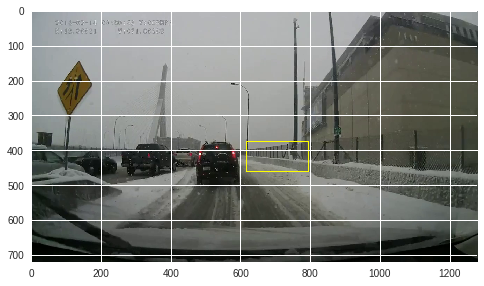

In [58]:
runvideo(clip1)

**colab file download**

In [0]:

files.download("output.mp4")

https://medium.com/@xslittlegrass/almost-real-time-vehicle-detection-using-yolo-da0f016b43de


https://pjreddie.com/darknet/


Koch, Gregory, Richard Zemel, and Ruslan Salakhutdinov. "Siamese neural networks for one-shot image recognition." ICML Deep Learning Workshop. Vol. 2. 2015.


https://docs.opencv.org/3.4/d9/df8/group__tracking.html